In [16]:
%matplotlib inline

import numpy.random as npr
import math
import matplotlib.pyplot as plt

from tqdm import tqdm

In [17]:
import sys
sys.path.append("/home/hofmann/nngame/package/src/rlbase/")
from importlib import reload

import env_bandit
import agent_greedy
import misc
from rl_glue import RLGlue
reload(env_bandit)
reload(agent_greedy)
reload(misc)

<module 'misc' from '/home/hofmann/nngame/package/src/rlbase/misc.py'>

Figure 2.2. Average performance of $\epsilon$-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.

In [ ]:
k = 10

N_timesteps = 1000
N_bandits = 2000

arr_eps = [0,0.01,0.1]

env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:[0]*N_timesteps for i in arr_eps}
optimal_actions = {i:[0]*N_timesteps for i in arr_eps}
for bandit in tqdm(range(N_bandits)):
  for eps in arr_eps:

    agent = agent_greedy.EpsGreedyAgent
    agent_info = {"num_actions": k, "epsilon": eps}    
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[eps][t] += reward / N_bandits
      optimal_actions[eps][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for e in arr_eps:
  plt.plot(results[e])
plt.legend(["eps="+str(e) for e in arr_eps])

plt.subplot(2,1,2)
for e in arr_eps:
  plt.plot(optimal_actions[e])
plt.legend(["eps="+str(e) for e in arr_eps])

plt.show()

Exercise 2.5: Demonstrate the difficulties that sample-average methods have for nonstationary problems.

In [ ]:
k = 10

N_timesteps = 10000
N_bandits = 1000

env = env_bandit.BanditEnvironment    
env_info = {"N": k, "random":True}

stepsizes = ["SampleAverage", "ConstantStepsize"]

results         = {i:[0]*N_timesteps for i in stepsizes}
optimal_actions = {i:[0]*N_timesteps for i in stepsizes}
for bandit in tqdm(range(N_bandits)):
  for s in stepsizes:
    agent = agent_greedy.EpsGreedyAgent
    if s == "SampleAverage":
        agent_info = {"num_actions": k, "epsilon": 0.1}    
    else:
        agent_info = {"num_actions": k, "epsilon": 0.1, "step_size": 0.1}    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    for t in range(N_timesteps):
      best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
      reward, _, action, _ = rl_glue.rl_step()
      results[s][t] += reward / N_bandits
      optimal_actions[s][t] += (action==best_action) / N_bandits   
        
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for e in stepsizes:
  plt.plot(results[e])
plt.legend(stepsizes)

plt.subplot(2,1,2)
for e in stepsizes:
  plt.plot(optimal_actions[e])
plt.legend(stepsizes)

plt.show()

Figure 2.3: The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods use a constant step-size parameter, $\alpha=0.1$.

100%|██████████| 1000/1000 [00:39<00:00, 25.18it/s]


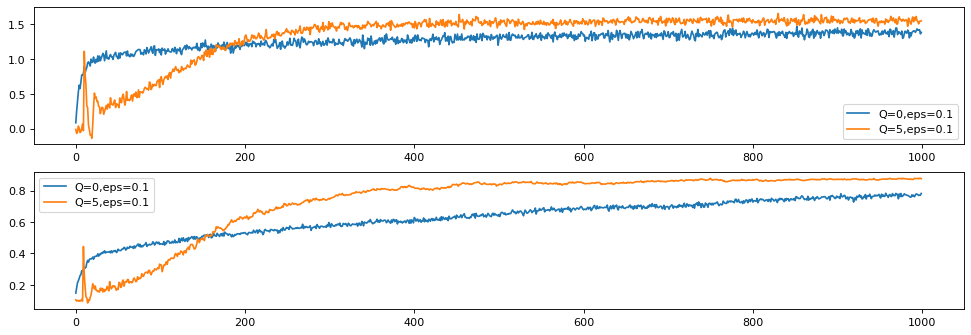

In [15]:
k = 10

N_timesteps = 1000
N_bandits = 1000

agent_info_1 = {"num_actions": k, "epsilon": 0.1, "step_size":0.1, "initial_value": 0}
agent_info_2 = {"num_actions": k, "epsilon": 0  , "step_size":0.1, "initial_value": 5}

agent_infos = {"Q="+str(e["initial_value"])+",eps="+str(e["step_size"]):e for e in [agent_info_1, agent_info_2]}

env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  for k,agent_info in agent_infos.items():

    agent = agent_greedy.EpsGreedyAgent
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[k][t] += reward / N_bandits
      optimal_actions[k][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for agent_info in agent_infos:
  plt.plot(results[agent_info])
plt.legend(agent_infos.keys())

plt.subplot(2,1,2)
for agent_info in agent_infos:
  plt.plot(optimal_actions[agent_info])
plt.legend(agent_infos.keys())

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/hofmann/nngame/package/src/rlbase/agent_greedy.py:46: RuntimeWarning: invalid value encountered in true_divide
  pass
/home/hofmann/nngame/package/src/rlbase/agent_greedy.py:46: RuntimeWarning: divide by zero encountered in true_divide
  pass
100%|██████████| 1000/1000 [00:49<00:00, 20.33it/s]


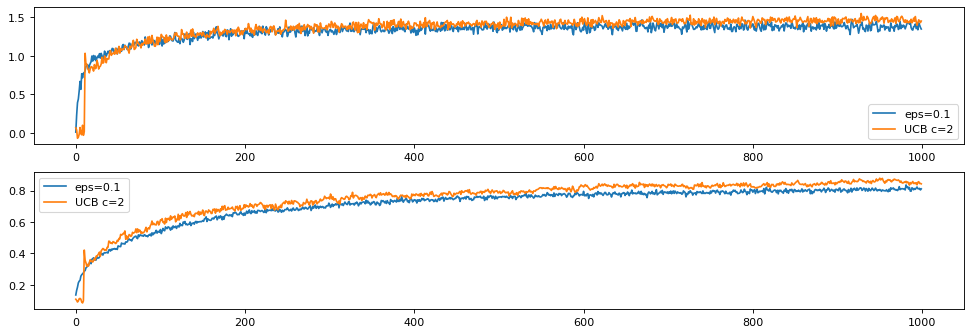

In [18]:
k = 10

N_timesteps = 1000
N_bandits = 1000

agent_info_1 = {"num_actions": k, "epsilon": 0.1}
agent_info_2 = {"num_actions": k, "ucb_c":2}

agent_infos = dict(zip(["eps=0.1","UCB c=2"],[agent_info_1, agent_info_2]))

env = env_bandit.BanditEnvironment    
env_info = {"N": k}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  for k,agent_info in agent_infos.items():

    agent = agent_greedy.EpsGreedyAgent
    
    rl_glue = RLGlue(env, agent)          
    rl_glue.rl_init(agent_info, env_info) 
    rl_glue.rl_start()                    

    best_action = list(rl_glue.environment.arms).index(max(rl_glue.environment.arms))
    for t in range(N_timesteps):
      reward, _, action, _ = rl_glue.rl_step()
      results[k][t] += reward / N_bandits
      optimal_actions[k][t] += (action==best_action) / N_bandits
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
for agent_info in agent_infos:
  plt.plot(results[agent_info])
plt.legend(agent_infos.keys())

plt.subplot(2,1,2)
for agent_info in agent_infos:
  plt.plot(optimal_actions[agent_info])
plt.legend(agent_infos.keys())

plt.show()